# Septin Analysis: comparing the mean shape of each group

# 1. Overview of analysis

First, we will

# 2. Imports

## 2.1 Notebook setup

In [136]:
import os
import subprocess
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

Working directory:  /Users/adelemyers/code/dyn


## 2.2 Standard Imports

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [138]:
from geomstats.learning.pca import TangentPCA

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## 2.3 Project-specific imports

In [139]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.learning.pca import TangentPCA

import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.basic as basic
import dyn.viz as viz

viz.init_matplotlib()
%config InlineBackend.figure_formats = ['svg']

# 3. Setup

## 3.1 Load the datasets of interest

In [165]:
import dyn.dyn.datasets.experimental as experimental

#this forces the notebook to re-load
import importlib
importlib.reload(experimental)

control_centers, control_shapes, control_imgs, control_label = experimental.load_septin_cells( 'control',
    n_sampling_points=1000)

knockdown_centers, knockdown_shapes, knockdown_imgs, knockdown_label = experimental.load_septin_cells( 'septin_knockdown',
    n_sampling_points=1000)

overexp_centers, overexp_shapes, overexp_imgs, overexp_label = experimental.load_septin_cells( 'septin_overexpression',
    n_sampling_points=1000)

Loading control data
n_sampling_points= 1000
Loading septin_knockdown data
n_sampling_points= 1000
Loading septin_overexpression data
n_sampling_points= 1000


## 3.2 Define Shape Spaces

In [166]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
    
    
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

# 4. Sample Means

## 4.1 Control Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [167]:
means = {}

means["Linear"] = gs.mean(control_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        point_type="matrix", 
        method="default").fit(control_shapes).estimate_
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            point_type="matrix", 
            method="default").fit(control_shapes).estimate_

Now, we plot the cell shapes corresponding to the means with different metrics.

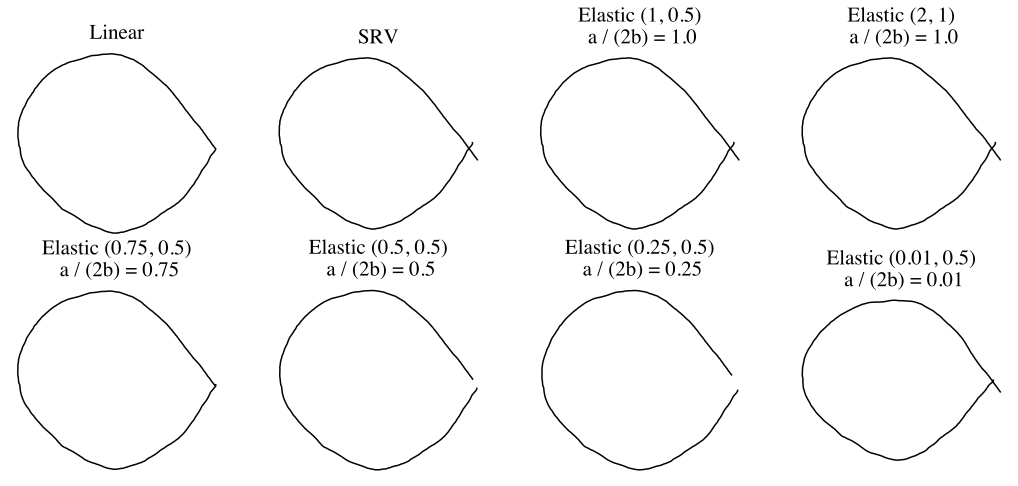

In [168]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

## 4.2 Septin Knockdown Means

In [157]:
means = {}

means["Linear"] = gs.mean(knockdown_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        point_type="matrix", 
        method="default").fit(knockdown_shapes).estimate_
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            point_type="matrix", 
            method="default").fit(knockdown_shapes).estimate_

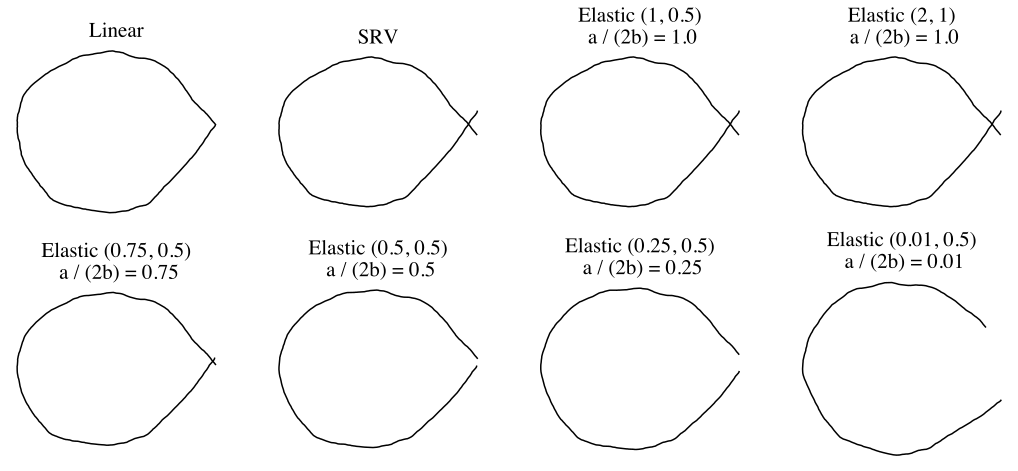

In [158]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

## 4.2 Septin Overexpression Means

In [159]:
means = {}

means["Linear"] = gs.mean(overexp_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        point_type="matrix", 
        method="default").fit(overexp_shapes).estimate_
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            point_type="matrix", 
            method="default").fit(overexp_shapes).estimate_

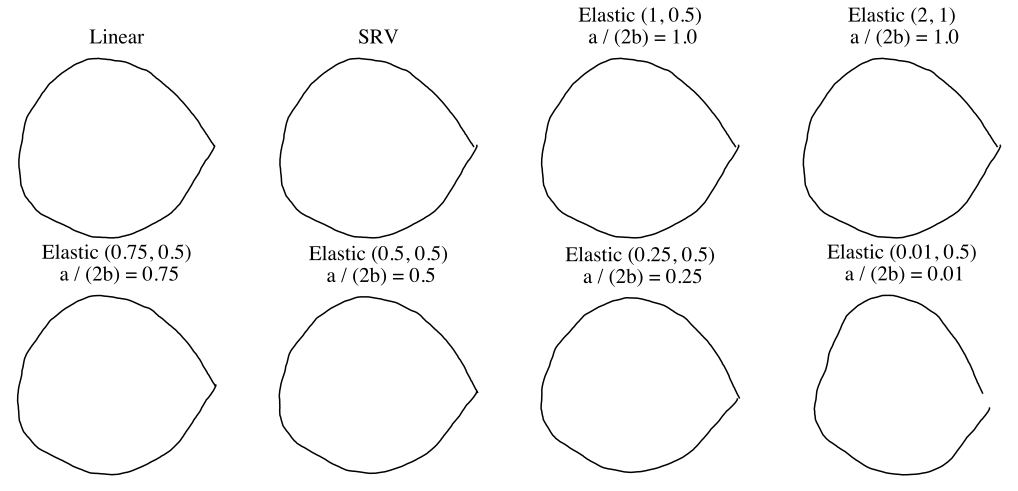

In [160]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

I think that the issue here is that all of this code is meant for something where the shape of list_tifs is bigger than the example case.

yes, so what is happening is that it think that each file in the example is its own "movie"/set of trajectories, and in our case, we are considering just a bunch of single images. so the example list_tifs has an extra dimension. so we shouldnt even be considering the variable n_tifs

yeah, so i was right. now, do the function below and just do it for each one because everything is set up differently from eample (list_tifs is different than actually just creating a list).

In [10]:
def load_septin_cells(n_cells=-1, n_sampling_points=10):
    n_sampling_points=10
    n_cells=-1

    list_tifs = experimental.load_septin_cells(n_cells,n_sampling_points)

    #n_traj = len(list_tifs)
    #print(n_traj)
    #before, this was called one_img_stack because it was used to come up with n_time_points and other variables
    #because before, there were multiple image stacks. here, list_tifs is one image stack, so we will change
    #one_img_stack -> img_stack
    img_stack = skio.imread(list_tifs, plugin="tifffile")
    print(img_stack.shape)
    n_time_points, height, width = img_stack.shape

    #centers_traj = gs.zeros((n_traj, n_time_points, 2))
    #shapes_traj = gs.zeros((n_traj, n_time_points, n_sampling_points, 2))
    #imgs_traj = gs.zeros((n_traj, n_time_points, height, width))

    centers_traj = gs.zeros((n_time_points, 2))
    shapes_traj = gs.zeros((n_time_points, n_sampling_points, 2))
    imgs_traj = gs.zeros((n_time_points, height, width))


    labels = []
    #for i_traj, video_path in enumerate(list_tifs):
        #video_name = os.path.basename(video_path)
        #print(f"\n Processing trajectory {i_traj+1}/{n_traj}.")

        #print(f"Converting {video_name} into list of cell contours...")

    #this converts all the images into a list of contours and images.
    contours_list, imgs_list = _tif_video_to_lists(list_tifs)

    #labels.append(int(video_name.split("_")[0]))
    for i_contour, (contour, img) in enumerate(zip(contours_list, imgs_list)):
        interpolated = _interpolate(contour, n_sampling_points)
        cleaned = _remove_consecutive_duplicates(interpolated)
        center = gs.mean(cleaned, axis=-2)
        centered = cleaned - center[..., None, :]
        centers_traj[i_contour] = center
        shapes_traj[i_contour] = centered
        if img.shape != (height, width):
            print(
                "Found image of a different size: "
                f"{img.shape} instead of {height, width}. "
                "Skipped image (not cell contours)."
            )
            continue
        imgs_traj[i_contour] = gs.array(img.astype(float).T)
    labels = gs.array(labels)
    return centers_traj, shapes_traj, imgs_traj, labels

In [5]:
import glob
import os

import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
import numpy as np
import skimage.io as skio
from geomstats.geometry.pre_shape import PreShapeSpace
from skimage import measure
from skimage.filters import threshold_otsu

import dyn.dyn.features.basic as basic


In [44]:

import dyn.dyn.datasets.experimental as experimental

import importlib
importlib.reload(experimental)



def _tif_video_to_lists(tif_path):
    """Convert a cell video into two trajectories of contours and images.

    Parameters
    ----------
    tif_path : absolute path of video in .tif format.

    Returns
    -------
    contours_list : list of arrays
        List of 2D coordinates of points defining the contours of each cell
        within the video.
    imgs_list : list of array
        List of images in the input video.
    """
    img_stack = skio.imread(tif_path, plugin="tifffile")
    contours_list = []
    imgs_list = []
    for img in img_stack:
        imgs_list.append(img)
        thresh = threshold_otsu(img)
        binary = img > thresh
        contours = measure.find_contours(binary, 0.8)
        lengths = [len(c) for c in contours]
        max_length = max(lengths)
        index_max_length = lengths.index(max_length)
        contours_list.append(contours[index_max_length])

    return contours_list, imgs_list

def _interpolate(curve, n_sampling_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Parameters
    ----------
    curve : array-like, shape=[n_points, 2]
    n_sampling_points : int

    Returns
    -------
    interpolation : array-like, shape=[n_sampling_points, 2]
       Discrete curve with n_sampling_points
    """
    old_length = curve.shape[0]
    interpolation = np.zeros((n_sampling_points, 2))
    incr = old_length / n_sampling_points
    pos = np.array(0.0, dtype=np.float32)
    for i in range(n_sampling_points):
        index = int(np.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return gs.array(interpolation, dtype=gs.float32)

def _remove_consecutive_duplicates(curve, tol=1e-2):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """
    dist = curve[1:] - curve[:-1]
    dist_norm = gs.sqrt(gs.sum(dist**2, axis=1))

    if gs.any(dist_norm < tol):
        for i in range(len(curve) - 1):
            if gs.sqrt(gs.sum((curve[i + 1] - curve[i]) ** 2, axis=0)) < tol:
                curve[i + 1] = (curve[i] + curve[i + 2]) / 2

    return curve



def load_septin_cells(n_cells=-1, n_sampling_points=10):
    n_sampling_points=10
    n_cells=-1

    control_path, knockdown_path, overexp_path, control_tifs, septin_knockdown_tifs, septin_overexpression_tifs = experimental.load_septin_cells(
        n_cells,n_sampling_points)
    
    list_tifs=control_tifs
    
    n_groups = 3
    
    """
    #n_traj = len(list_tifs)
    #print(n_traj)
    #before, this was called one_img_stack because it was used to come up with n_time_points and other variables
    #because before, there were multiple image stacks. here, list_tifs is one image stack, so we will change
    #one_img_stack -> img_stack
    """
    
    #finding dimensions of the control data
    control_img_stack = skio.imread(control_tifs, plugin="tifffile")
    print(control_img_stack.shape)
    c_n_time_points, c_height, c_width = control_img_stack.shape
    
    #finding the dimensions of the septin knockdown data
    knock_img_stack = skio.imread(septin_knockdown_tifs, plugin="tifffile")
    print(knock_img_stack.shape)
    k_n_time_points,k_height, k_width = knock_img_stack.shape
    
    #finding the dimensions of the septin overexpression data
    overexp_img_stack = skio.imread(septin_overexpression_tifs, plugin="tifffile")
    print(overexp_img_stack.shape)
    o_n_time_points,o_height, o_width = overexp_img_stack.shape
    
    #centers_traj = gs.zeros((n_groups, n_time_points, 2))
    #shapes_traj = gs.zeros((n_groups, n_time_points, n_sampling_points, 2))
    #imgs_traj = gs.zeros((n_groups, n_time_points, height, width))

    centers_control = gs.zeros((c_n_time_points, 2))
    shapes_control = gs.zeros((c_n_time_points, n_sampling_points, 2))
    imgs_control = gs.zeros((c_n_time_points, c_height, c_width))
    
    centers_knock = gs.zeros((k_n_time_points, 2))
    shapes_knock = gs.zeros((k_n_time_points, n_sampling_points, 2))
    imgs_knock = gs.zeros((k_n_time_points, k_height, k_width))
    
    centers_overexp = gs.zeros((o_n_time_points, 2))
    shapes_overexp = gs.zeros((o_n_time_points, n_sampling_points, 2))
    imgs_overexp = gs.zeros((o_n_time_points, o_height, o_width))


    labels = []
    
    video_name = os.path.basename(os.path.dirname(os.path.dirname(control_path)))
    print(video_name)
    
    #for i_traj, video_path in enumerate(list_tifs):
        #video_name = os.path.basename(video_path)
        #print(f"\n Processing trajectory {i_traj+1}/{n_traj}.")

        #print(f"Converting {video_name} into list of cell contours...")

    #this converts all the images into a list of contours and images.
    contours_list, imgs_list = _tif_video_to_lists(list_tifs)

    #labels.append(int(video_name.split("_")[0]))
    for i_contour, (contour, img) in enumerate(zip(contours_list, imgs_list)):
        interpolated = _interpolate(contour, n_sampling_points)
        cleaned = _remove_consecutive_duplicates(interpolated)
        center = gs.mean(cleaned, axis=-2)
        centered = cleaned - center[..., None, :]
        centers_traj[i_contour] = center
        shapes_traj[i_contour] = centered
        if img.shape != (height, width):
            print(
                "Found image of a different size: "
                f"{img.shape} instead of {height, width}. "
                "Skipped image (not cell contours)."
            )
            continue
        imgs_traj[i_contour] = gs.array(img.astype(float).T)
    labels = gs.array(labels)
    return centers_traj, shapes_traj, imgs_traj, labels

In [ ]:
"""

def load_septin_cells(n_cells=-1, n_sampling_points=10):
    

    Load dataset of septin cells.
    
    There are three groups that we are considering: control, Septin Knockdown, Septin Overexpression.
    
    Notes
    -----
    There are 36 tif files in Control -> binary files
    There are 45 tif files in Septin Knockdown -> binary files
    There are 36 tif files in Septin Overexpression -> binary files
    
    
    
    dataset_dir = os.path.dirname(os.path.realpath(__file__))
    
    #os.path.join finds the path that leads you to the file
    #glob.glob finds and returns the file you are looking for and returns the data.
    control_path = os.path.join(dataset_dir, "septin_groups/Control/binary_images/*.tif")
    control_tifs = glob.glob(control_path
        #os.path.join(dataset_dir, "septin_groups/Control/binary_images/*.tif")
    )
    
    knockown_path = os.path.join(dataset_dir, "septin_groups/septin_knockdown/binary_images/*.tif")
    septin_knockdown_tifs = glob.glob(
        knockdown_path
    )
    
    
    overexp_path = os.path.join(dataset_dir, "septin_groups/septin_overexpression/binary_images/*.tif")
    septin_overexpression_tifs = glob.glob( overexp_path
    )
    
    
    
    return control_path, knockdown_path, overexp_path, control_tifs, septin_knockdown_tifs, septin_overexpression_tifs
"""